# Euro-Coin Classifier


## Check if the GPU is being used

In [1]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


## Required imports and previous configuration

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

## Data augmentation with generator

In [3]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array
'''

image_size = (200, 200) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,          # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorio con las imagenese originales
source_dir = '../datasets/coins_final/all'

# Directorio de salida para las imágenes aumentadas
augmented_dir = '../datasets/coins_final/augmented_all'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='png'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(source_dir, augmented_dir, data_augmentation)

'''

"\n\nimage_size = (200, 200) \nbatch_size = 16\n\n# Configuración del generador de aumento de datos\ndata_augmentation = ImageDataGenerator(\n    rescale=1./255,                 # Normalización de los valores de píxeles\n    rotation_range=40,              # Grados de rotación aleatoria\n    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio\n    height_shift_range=0.1,         # Desplazamiento vertical aleatorio\n    shear_range=0.1,                # Cizalla aleatoria\n    zoom_range=0.1,                 # Rango de zoom aleatorio\n    channel_shift_range=5,          # Cambios aleatorios en los canales de colores\n    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio\n    horizontal_flip=True,           # Activar volteo horizontal\n    vertical_flip=True,             # Activar volteo vertical\n    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales\n)\n\n# Directorio con las imagenese originales\nsource_dir =

In [4]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (200, 200) 
batch_size = 64
data_dir = os.path.join('..','datasets', 'coins_final', 'augmented_all')

train_dir = os.path.join('../datasets/coins_final/redistributed_all/train') 
valid_dir = os.path.join('../datasets/coins_final/redistributed_all/valid') 
test_dir = os.path.join('../datasets/coins_final/redistributed_all/test')  

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)
# '''

Found 5783 files belonging to 8 classes.
Found 1653 files belonging to 8 classes.
Found 831 files belonging to 8 classes.


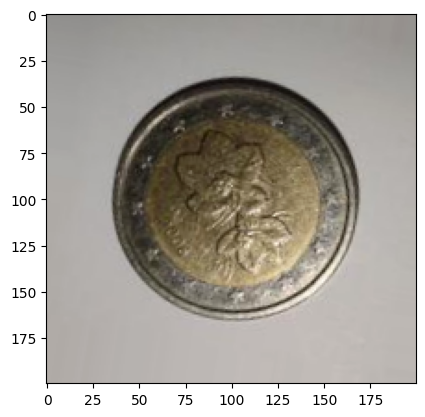

In [5]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('../datasets/coins_final/redistributed_all/train/2e/2e_0_3903.png', 'r')
imshow(np.asarray(pil_im))

## Model definition and configuration 

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping


model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(200,200,3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

# Capa totalmente conectada
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(8, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
# Resumen del modelo
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 196, 196, 32)      2432      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 128)      

## Training

In [12]:
epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es],
        # steps_per_epoch=200 # (steps_per_epoch = total_samples / batch_size)
)

# model = tf.keras.models.load_model('trained_models/coins_model.h5') # Load the model
model.save('trained_models/coins_model.h5')  # Save as HDF5 file

Epoch 1/100


91/91 [==============================] - 11s 98ms/step - loss: 1.9777 - accuracy: 0.2106 - val_loss: 1.9247 - val_accuracy: 0.2874
Epoch 2/100
91/91 [==============================] - 8s 83ms/step - loss: 1.7976 - accuracy: 0.2917 - val_loss: 1.4771 - val_accuracy: 0.3829
Epoch 3/100
91/91 [==============================] - 8s 83ms/step - loss: 1.5209 - accuracy: 0.3908 - val_loss: 1.4316 - val_accuracy: 0.4338
Epoch 4/100
91/91 [==============================] - 8s 82ms/step - loss: 1.3727 - accuracy: 0.4486 - val_loss: 1.3537 - val_accuracy: 0.4356
Epoch 5/100
91/91 [==============================] - 8s 83ms/step - loss: 1.2335 - accuracy: 0.5241 - val_loss: 1.1412 - val_accuracy: 0.5705
Epoch 6/100
91/91 [==============================] - 8s 82ms/step - loss: 1.1194 - accuracy: 0.5869 - val_loss: 0.9137 - val_accuracy: 0.6576
Epoch 7/100
91/91 [==============================] - 8s 82ms/step - loss: 0.9357 - accuracy: 0.6483 - val_loss: 0.7824 - val_accuracy: 0.7120
Epoch 8/100
91/91

## Graphical representation of results

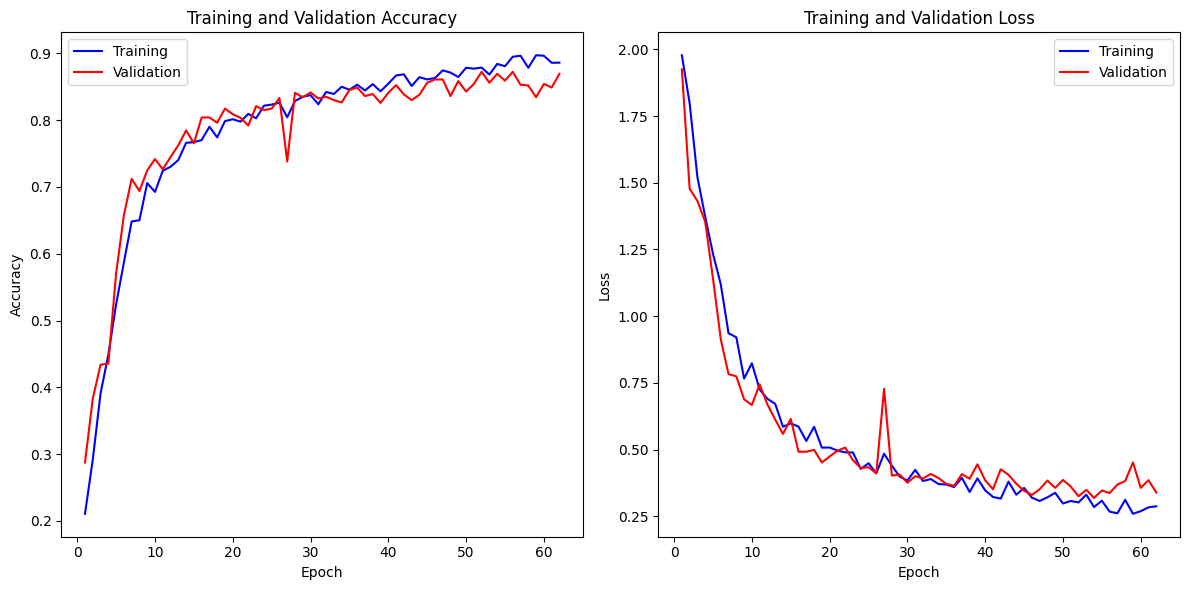

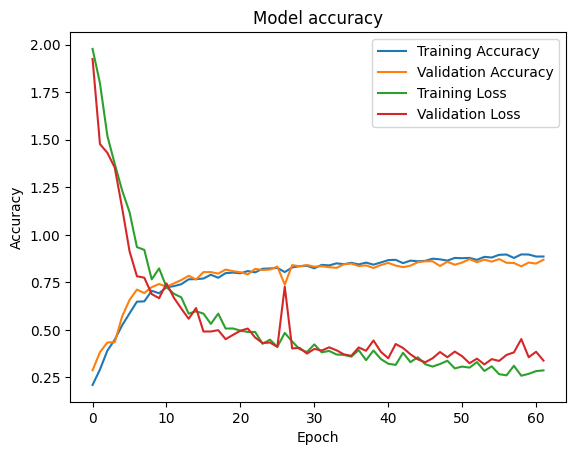

In [13]:
import matplotlib.pyplot as plt

def separate_plot(h):
    # Extracción de datos
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def combined_plot(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model accuracy')    
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
    plt.show()

#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h)

# Generate combined results plot
combined_plot(h)

## Evaluation of results

Found 831 files belonging to 8 classes.
2/2 [==============================] - 0s 330ms/step


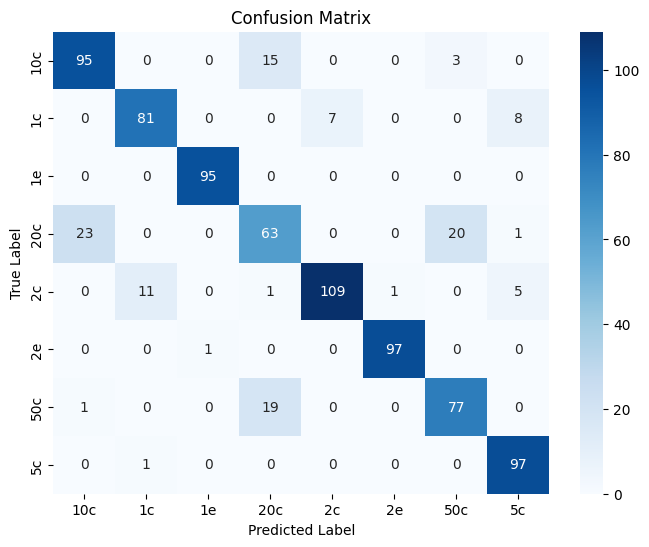

              precision    recall  f1-score   support

         10c     0.7983    0.8407    0.8190       113
          1c     0.8710    0.8438    0.8571        96
          1e     0.9896    1.0000    0.9948        95
         20c     0.6429    0.5888    0.6146       107
          2c     0.9397    0.8583    0.8971       127
          2e     0.9898    0.9898    0.9898        98
         50c     0.7700    0.7938    0.7817        97
          5c     0.8739    0.9898    0.9282        98

    accuracy                         0.8592       831
   macro avg     0.8594    0.8631    0.8603       831
weighted avg     0.8583    0.8592    0.8578       831



In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory

def split_labels(labels, max_length):
    """
    Format long labels by adding line breaks.

    Args:
    labels (list of str): Original list of labels.
    max_length (int): Maximum line length in a label.

    Returns:
    list of str: Labels with line breaks added.
    """
    formatted_labels = []
    for label in labels:
        if len(label) <= max_length:
            formatted_labels.append(label)
            continue

        # Split label into words and construct new label with line breaks
        words = label.split()
        new_label = words[0]
        for word in words[1:]:
            if len(new_label + ' ' + word) <= max_length:
                new_label += ' ' + word
            else:
                new_label += '\n' + word
        formatted_labels.append(new_label)
    
    return formatted_labels


def evaluate_model(test_dir, model, test_ds, max_label_length=15):
    """
    Function to evaluate a model with a validation dataset.
    Displays the confusion matrix and classification report.

    Args:
    test_dir (str): Test dataset directory to load class names
    model (keras.Model): Model to evaluate.
    test_ds (tf.data.Dataset): Test dataset.
    max_label_length (int): Maximum allowed label length before splitting at word boundaries.
    """
    # Load class names and plit long labels at word boundaries
    class_names = split_labels(labels=image_dataset_from_directory(directory=test_dir).class_names,
                               max_length= max_label_length)
    
    # Generate predictions and true labels
    results = np.concatenate([(y.numpy(), model.predict(x)) for x, y in test_ds], axis=1)
    predictions = np.argmax(results[1], axis=1)
    labels = np.argmax(results[0], axis=1)

    # Calculate the confusion matrix with formatted labels
    cf_matrix = confusion_matrix(labels, predictions)

    # Create a heatmap for the confusion matrix with formatted labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
                          xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Display the classification report with formatted labels
    formatted_labels = split_labels(class_names, max_label_length)
    formatted_classification_report = classification_report(labels, predictions, target_names=formatted_labels, digits=4)
    print(formatted_classification_report)

# Example usage:
evaluate_model(test_dir, model, test_ds, max_label_length=11)


# VGG16 (Visual Geometry Group) CNN-Net

## Model configuration and training

**Explanation of "Inference Mode"**

When it's said that the "base model is in inference mode," it means that the model is being used for making predictions (inferences) rather than for training. This is important when using a pretrained model and only wanting to fine-tune the last layers without modifying the previously learned weights in the earlier layers.

In TensorFlow and Keras, this is achieved by setting `training=False` when calling the base model. This way, the model won't update its weights during the backpropagation process, preserving the previously learned weights.

**Other Modes:**

1. **Training Mode**: This is when `training=True`. In this mode, all training-related operations, such as gradient computation and weight updates, are active.

2. **Inference Mode**: `training=False` indicates that the model is being used to make predictions. Training-specific operations like dropout or batch normalization layers behave differently in this mode to reflect that the model is not being trained.

Using the correct mode is crucial for achieving the expected results, especially when working with pretrained models and performing fine-tuning.

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(
    weights='imagenet', 
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG16 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning, as
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG16 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_VGG16.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg16 = model_with_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

# Save the trained model
model_with_VGG16.save('trained_models/coins_model_with_VGG16.h5')  # Save as HDF5 file


Epoch 1/50
91/91 [==============================] - 34s 310ms/step - loss: 1.2572 - accuracy: 0.6552 - val_loss: 0.5556 - val_accuracy: 0.8125
Epoch 2/50
91/91 [==============================] - 20s 216ms/step - loss: 0.3394 - accuracy: 0.8821 - val_loss: 0.4288 - val_accuracy: 0.8536
Epoch 3/50
91/91 [==============================] - 19s 208ms/step - loss: 0.2127 - accuracy: 0.9289 - val_loss: 0.3230 - val_accuracy: 0.8875
Epoch 4/50
91/91 [==============================] - 19s 209ms/step - loss: 0.1307 - accuracy: 0.9628 - val_loss: 0.2659 - val_accuracy: 0.9141
Epoch 5/50
91/91 [==============================] - 19s 210ms/step - loss: 0.0954 - accuracy: 0.9741 - val_loss: 0.2634 - val_accuracy: 0.9099
Epoch 6/50
91/91 [==============================] - 19s 208ms/step - loss: 0.0751 - accuracy: 0.9812 - val_loss: 0.2391 - val_accuracy: 0.9183
Epoch 7/50
91/91 [==============================] - 19s 208ms/step - loss: 0.0532 - accuracy: 0.9886 - val_loss: 0.2171 - val_accuracy: 0.9274

## Graphical representation of results

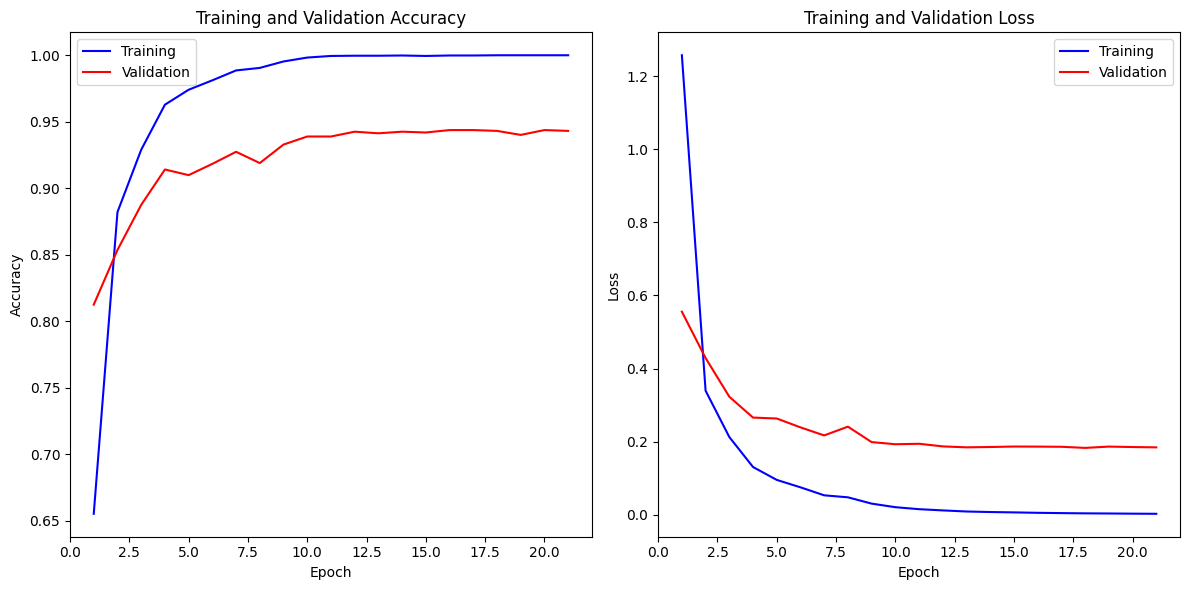

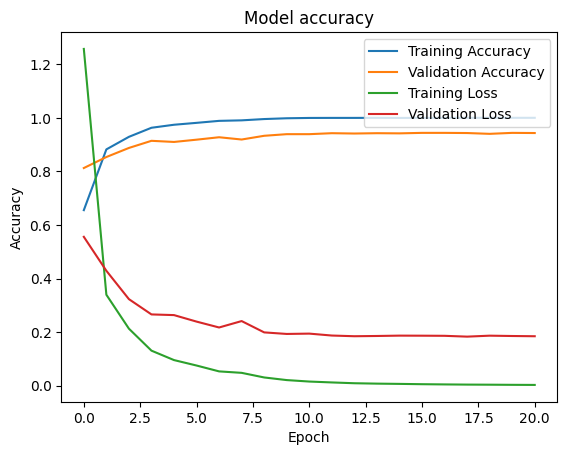

In [32]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h_vgg16)

# Generate combined results plot
combined_plot(h_vgg16)

## Evaluation of results

Found 831 files belonging to 8 classes.
2/2 [==============================] - 4s 4s/step


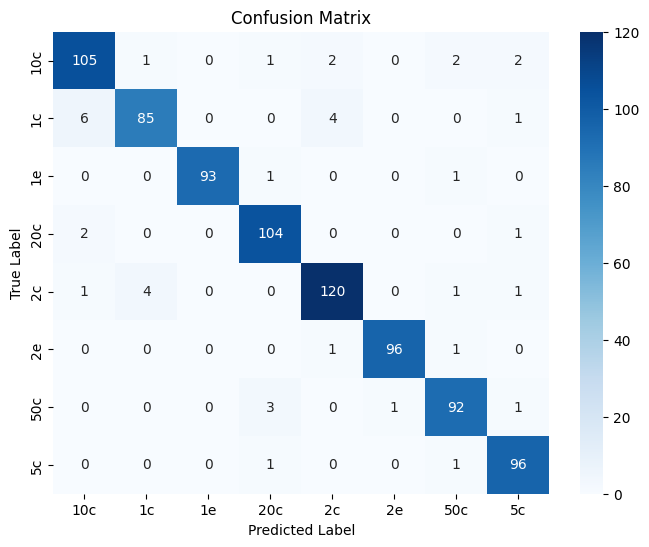

              precision    recall  f1-score   support

         10c     0.9211    0.9292    0.9251       113
          1c     0.9444    0.8854    0.9140        96
          1e     1.0000    0.9789    0.9894        95
         20c     0.9455    0.9720    0.9585       107
          2c     0.9449    0.9449    0.9449       127
          2e     0.9897    0.9796    0.9846        98
         50c     0.9388    0.9485    0.9436        97
          5c     0.9412    0.9796    0.9600        98

    accuracy                         0.9519       831
   macro avg     0.9532    0.9523    0.9525       831
weighted avg     0.9521    0.9519    0.9518       831



In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_VGG16, test_ds, max_label_length=11)


# VGG19 (Visual Geometry Group) CNN-Net

## Model configuration and training

In [36]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG19 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG19 = keras.Model(inputs=input_layer, outputs=output_layer)
model_with_VGG19.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg19 = model_with_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

model_with_VGG19.save('trained_models/coins_model_with_VGG19.h5')  # Save as HDF5 file


Epoch 1/50
91/91 [==============================] - 25s 263ms/step - loss: 1.3756 - accuracy: 0.6139 - val_loss: 0.5986 - val_accuracy: 0.7804
Epoch 2/50
91/91 [==============================] - 23s 247ms/step - loss: 0.4162 - accuracy: 0.8513 - val_loss: 0.4375 - val_accuracy: 0.8530
Epoch 3/50
91/91 [==============================] - 24s 259ms/step - loss: 0.2491 - accuracy: 0.9179 - val_loss: 0.3385 - val_accuracy: 0.8778
Epoch 4/50
91/91 [==============================] - 26s 279ms/step - loss: 0.1944 - accuracy: 0.9367 - val_loss: 0.2823 - val_accuracy: 0.8990
Epoch 5/50
91/91 [==============================] - 23s 248ms/step - loss: 0.1346 - accuracy: 0.9602 - val_loss: 0.2995 - val_accuracy: 0.8923
Epoch 6/50
91/91 [==============================] - 23s 250ms/step - loss: 0.1055 - accuracy: 0.9689 - val_loss: 0.2487 - val_accuracy: 0.9123
Epoch 7/50
91/91 [==============================] - 23s 248ms/step - loss: 0.0734 - accuracy: 0.9815 - val_loss: 0.2509 - val_accuracy: 0.9135

## Graphical representation of results

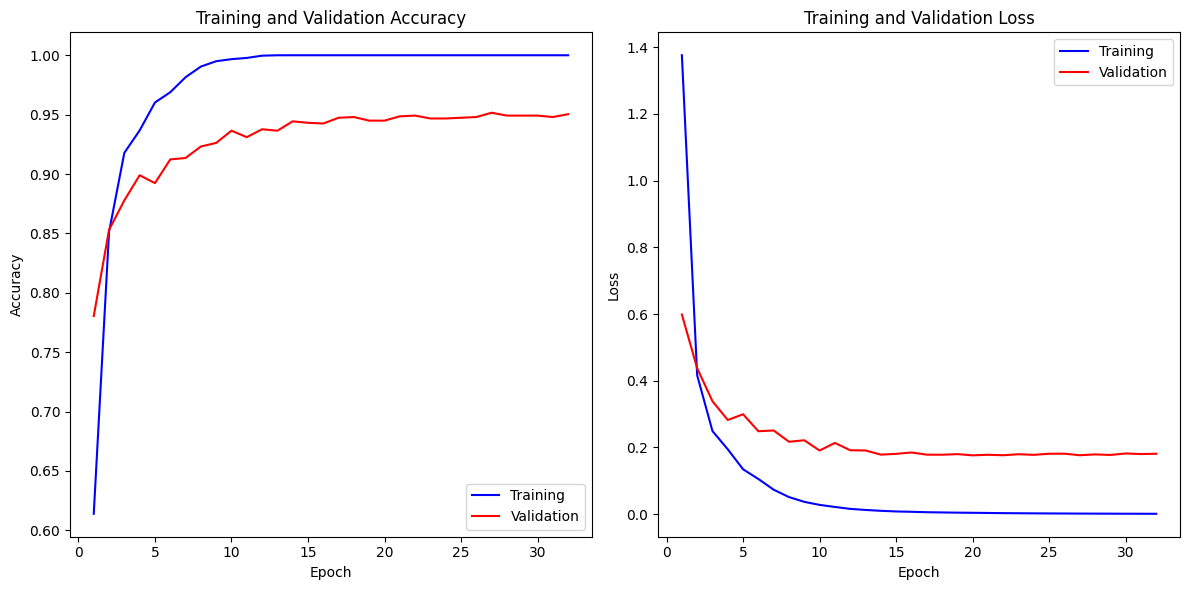

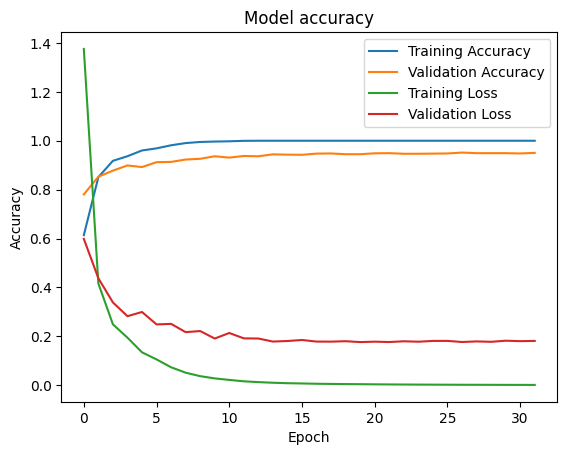

In [37]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h_vgg19)

# Generate combined results plot
combined_plot(h_vgg19)

## Evaluation of results

Found 831 files belonging to 8 classes.
2/2 [==============================] - 0s 98ms/step


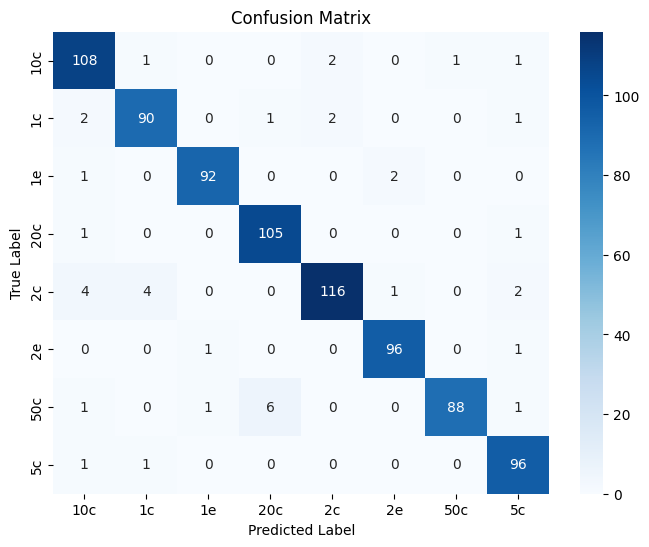

              precision    recall  f1-score   support

         10c     0.9153    0.9558    0.9351       113
          1c     0.9375    0.9375    0.9375        96
          1e     0.9787    0.9684    0.9735        95
         20c     0.9375    0.9813    0.9589       107
          2c     0.9667    0.9134    0.9393       127
          2e     0.9697    0.9796    0.9746        98
         50c     0.9888    0.9072    0.9462        97
          5c     0.9320    0.9796    0.9552        98

    accuracy                         0.9519       831
   macro avg     0.9533    0.9528    0.9525       831
weighted avg     0.9528    0.9519    0.9518       831



In [38]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_VGG19, test_ds, max_label_length=11)


# ResNet50 (Residual Neural Network) CNN-Net

## Model configuration and training

In [39]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the ResNet50 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = Input(shape=(200, 200, 3))

# Use the base model as a feature extractor: Setting training=False ensures that it operates in inference mode.
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
pooled_features = GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = Dense(256, activation='relu')(pooled_features)

# Output layer for classification into 8 classes
output_layer = Dense(8, activation='softmax')(dense_layer)

# Create the final model
model_with_resnet50 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es_callback = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
history_resnet50 = model_with_resnet50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es_callback]
)

model_with_resnet50.save('trained_models/coins_model_with_resnet50.h5')  # Save as HDF5 file


Epoch 1/50
91/91 [==============================] - 15s 142ms/step - loss: 0.7137 - accuracy: 0.7496 - val_loss: 0.3319 - val_accuracy: 0.8996
Epoch 2/50
91/91 [==============================] - 12s 128ms/step - loss: 0.2540 - accuracy: 0.9201 - val_loss: 0.2442 - val_accuracy: 0.9244
Epoch 3/50
91/91 [==============================] - 12s 128ms/step - loss: 0.1946 - accuracy: 0.9346 - val_loss: 0.2103 - val_accuracy: 0.9322
Epoch 4/50
91/91 [==============================] - 12s 127ms/step - loss: 0.1147 - accuracy: 0.9668 - val_loss: 0.2242 - val_accuracy: 0.9105
Epoch 5/50
91/91 [==============================] - 12s 127ms/step - loss: 0.0958 - accuracy: 0.9713 - val_loss: 0.1894 - val_accuracy: 0.9316
Epoch 6/50
91/91 [==============================] - 12s 128ms/step - loss: 0.0620 - accuracy: 0.9862 - val_loss: 0.1382 - val_accuracy: 0.9564
Epoch 7/50
91/91 [==============================] - 12s 135ms/step - loss: 0.0432 - accuracy: 0.9914 - val_loss: 0.1540 - val_accuracy: 0.9431

## Graphical representation of results

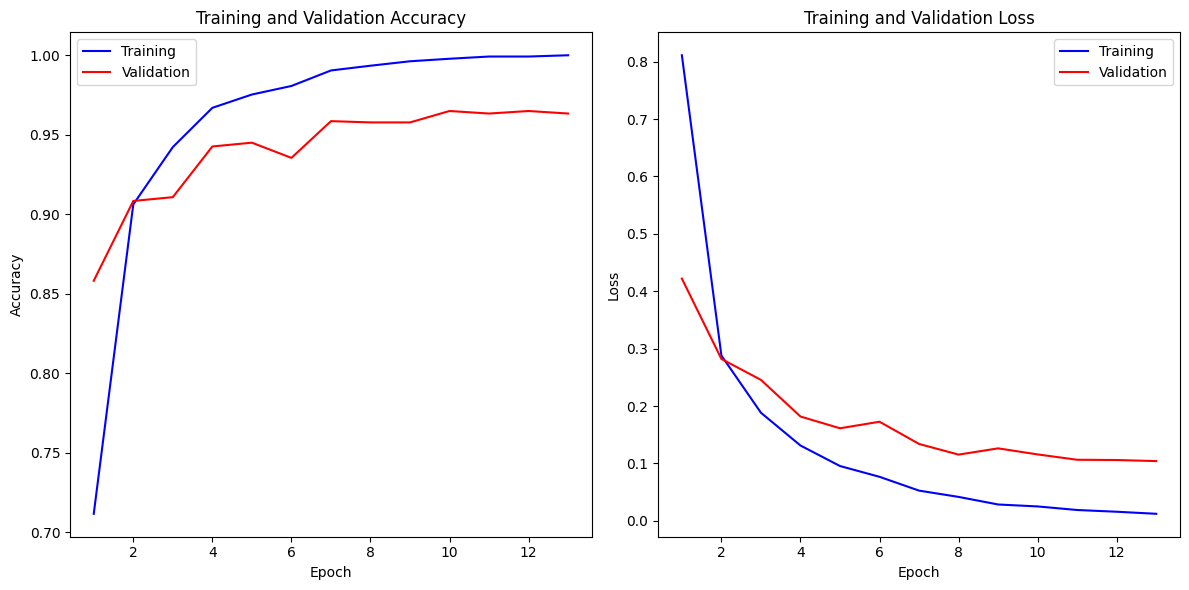

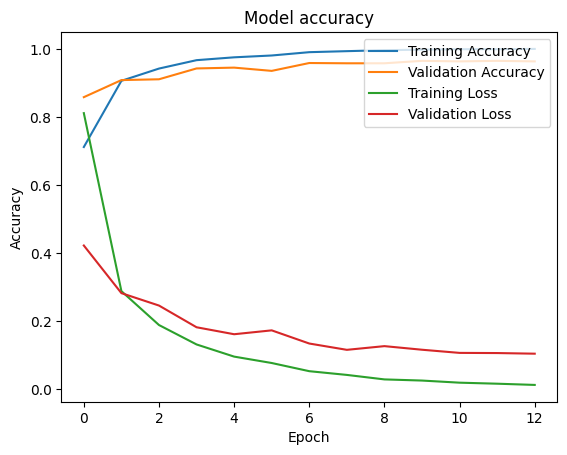

In [39]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(history_resnet50)

# Generate combined results plot
combined_plot(history_resnet50)

## Evaluation of results

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_resnet50, test_ds, max_label_length=11)
